---

##  The Grover Algorithm: Implementation

_course: quantum cryptography for beginners
<br>date: 11 november 2024
<br>author: burton rosenberg_

---


In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, Pauli 
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from IPython.display import display, Math, HTML
import time, math
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

print(f'\nqiskit version: {qiskit.version.get_version_info()}\n')

import math
import numpy as np
import matplotlib.pyplot as plt


qiskit version: 1.1.2




### Implementing the reflection

To implement the Grover Algorithm we need to implement two refections. The oracle reflection:

$$
U_f:\;|\phi\rangle \longrightarrow \sum_i (-1)^{(i==j)}\,|i\rangle
$$

and the flip around the average,

$$
    U_{r'} = 2 |h_0\rangle\langle h_0| - I
$$

Where $h_0$ is the result of putting zero through a bank of Hadamard transfomations,

$$
  h_0 = H^{n} |0\rangle
$$

and in general the Walsh-Hadamard basis is,

$$
 h_i = H^{n} |i\rangle
$$

The vectors in this basis are remarkably a pattern of +1's and -1's that described as,

$$
H^{n} |i\rangle = \sum_j (-1)^{i\cdot j}\,|i\rangle
$$

where $i\cdot j$ is the inner product in $\mathbb{F}_2{}^n$. For $n=4$, the table of $(-1)^{i\cdot j}$ is,


|  i &bsol; j | 0 | 1 | 2 | 3 |
| ---- | ---- | ---- | ---- | ---- |
| 0 | +1 | +1 | +1 | +1 |
| 1 | +1 | -1 | +1 | -1 |
| 2 | +1 | +1 | -1 | -1 |
| 3 | +1 | -1 | -1 | +1 |

In fact, we do not reflect around $h_0$ rather around its perpendicular in the plane containing it and the vector $|j\rangle$,
the vector representing the unknown. This upsets our plan by a minus sign, as the two reflections differ by a half rotation $x\rightarrow -x$,

\begin{eqnarray}
U_r &=& -U_{r'} \\
&=& I - 2 |h_0\rangle\langle h_0|  \\
&=& \sum_i |h_i\rangle \langle h_i | - 2 |h_0\rangle\langle h_0| \\
&=& \sum_i (-1)^{i==0}\, |h_i\rangle \langle h_i | 
\end{eqnarray}

The final element is how to reflect around $|i\rangle$, expressed as,

$$
U_i  = \sum_j (-1)^{i==j}\,\,|j\rangle
$$




### The Reflection around average

We implement,

$$
 I - 2 |h_0\rangle\langle h_0|
$$

We rotate the coordinate system to the $H$ basis $\{\, h_i = H^{\otimes n}|i\rangle\,\}$. In this basis our task is to 
negate the $|0\rangle$ vector and leave the rest unchanged. 

One way to do this is negate all qubits with $X$ gates
and take the logical and with a cascade of Toffoli gates and ancillas over all but one qubit. 
The reserved qubit and the result are acted upon by a controlled Z to effectuate the sign change.

Then we uncompute the "and cascade" to return the ancillas to zero and the $X$ inverts.



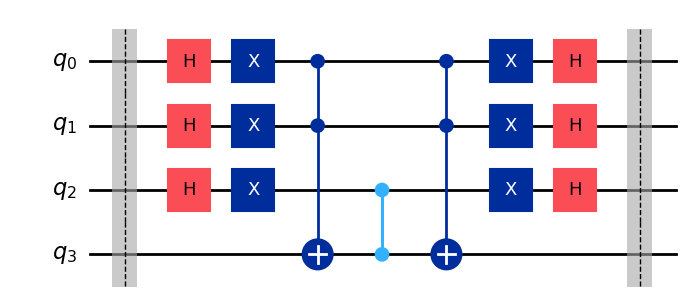

<IPython.core.display.Latex object>

True


In [2]:

# I - 2 |phi_0><phi_0|

# any output of the H except all one's should be fixed. 
# the all one's should invert (-1)
# and simple spikes should be -1/4 for all but 3/4 for the spike


np.set_printoptions(precision=2,floatmode='fixed',suppress=True)

def Ur_3(qc):
    for i in range(3):
        qc.h(i)
        qc.x(i)
    qc.ccx(0,1,3)
    qc.cz(3,2)
    qc.ccx(0,1,3)
    for i in range(3):
        qc.x(i)
        qc.h(i)
    qc.barrier()
    return qc


qc = QuantumCircuit(4)
qc.barrier()
Ur_3(qc)

sv = Statevector(qc)
display(qc.draw('mpl'))
display(sv.draw('latex'))
print(sv.equiv(sv))

### The Query Oracle Reflection

The querey reflection points out the hidden bit $j$ by the map 
$$
|i\rangle \mapsto (-1)^{i==j}|i\rangle.
$$
A standard almost classical combination of $X$ gates and a Toffoli cascade to take a logical and, completed with a controlled
$Z$ to apply the sign change; where the final $Z$ can include one of the qubits in the and as naturally part of its operation.

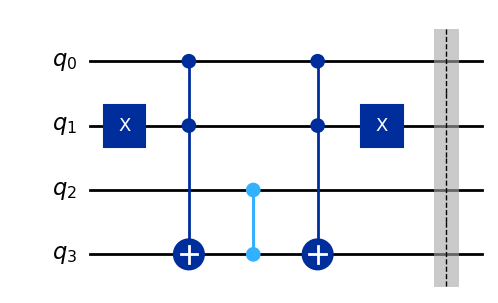

<IPython.core.display.Latex object>

In [3]:
### the reflection around |j>  => I - 2 |j><j|
### this is negating at the j-th index and can be done by Toffoli gates and a controlled Z


def reflect_j_3(qc,n,j):
    assert n==3
    assert qc.num_qubits==(n+1)
    j_save  = j
    for i in range (n):
        if j%2==0:
            qc.x(i)
        j = j//2 
    # in the case of 3
    qc.ccx(0,1,3)
    qc.cz(2,3)
    # uncompute
    qc.ccx(0,1,3)
    j = j_save
    for i in range (n):
        if j%2==0:
            qc.x(i)
        j = j//2 
    qc.barrier()
    return Statevector(qc), qc

n = 3
qc = QuantumCircuit(n+1)
sv, qc, = reflect_j_3(qc,n,5)
display(qc.draw('mpl'))
display(sv.draw('latex'))

### Simon's Iteration

Starting from $h_0$, iterate $R_j$ with $R_{h_0}$ for a precise number of iterations then measure. Here we iterate and watch, intent more on understanding the path of the Simon iteration than the result. 

A description I found common is the notion that the Simon's iteration distills out the answer, or some similar explanation. For instance, the reflection $R_{h_0}$ is around the average, and it is explained that with each iteration the probability weight is transfered from uniform towards an obseration of $|j\rangle$.

While that is true, it avoids considering what happens if one over-iterates; the state vector effortlessly continues its circular path past the "answer" configuration and the probabilty weight is transfered back toward the mean.

We demonstrate this in our experiment. 

Hence I feel the explanations that imply Simon's is deliberately solving this problem I feel are misleading.
The iteration,

- takes a state vector on a circular path that passes close to the answer vector,
- and gives the iterate at which it will be the closest.

What is remarkable is that the reflection can be done in time $O(n)$, whereas on a classical computer it would take time $O(N)$. The time to take the reflection is based on the depth needed to describe the transformation, which we found can be described compactly.


In [4]:
## try this out

def grover_iteration(qc,n,h):
    reflect_j_3(qc,n,h)
    Ur_3(qc)

# start with h_0
n = 3
h = 2  # hidden
qc = QuantumCircuit(n+1)
for i in range(n):
    qc.h(i)
qc.barrier()
display(0, Statevector(qc).draw('latex'))


total_phases = 2
for phase in range(total_phases):
    grover_iteration(qc,n,h)
    display(phase, Statevector(qc).draw('latex'))



0

<IPython.core.display.Latex object>

0

<IPython.core.display.Latex object>

1

<IPython.core.display.Latex object>

#### End